# Saliency
ABRIL: Chequear que esten bien los nombres de las etiquetas en 

In [3]:
%load_ext autoreload

In [4]:
%autoreload
import os
import numpy as np
import pandas as pd
import time
import pickle
from tqdm.notebook import tqdm
from numpy.lib.format import open_memmap
from itertools import combinations
#from pandarallel import pandarallel
from scipy.stats import multivariate_normal, entropy, pearsonr
from scripts.data import *
from scripts.preprocessing import *
from scripts.utils import *
from scripts.saliency_metrics import *

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale = 1.3)
%matplotlib inline

In [5]:
# load et data
results_path = './../results/'

# DeepGazeII
df_wk = pd.read_csv(os.path.join(results_path, 'WK', 'results_nss_wk.csv')) 
df_ff = pd.read_csv(os.path.join(results_path, 'FF', 'results_nss_ff.csv'))
df_tp = pd.read_csv(os.path.join(results_path, 'TP', 'results_nss_tp.csv'))

# load video data
videos_data = load_video_data()
trials_data = load_trials_data()

In [37]:
df_wk.shape, df_ff.shape,df_tp.shape

((690041, 9), (506665, 9), (684185, 9))

In [38]:
df_wk['ID'].unique().shape, df_ff['ID'].unique().shape, df_tp['ID'].unique().shape, 

((1669,), (944,), (1004,))

In [40]:
# comparo con los viejos
# load et data
results_path_old = './../results/debug/'

# DeepGazeII
df_wk_old = pd.read_csv(os.path.join(results_path_old, 'results_nss_wk.csv')) 
df_ff_old = pd.read_csv(os.path.join(results_path_old, 'results_nss_ff.csv'))
df_tp_old = pd.read_csv(os.path.join(results_path_old, 'results_nss_tp.csv'))

In [12]:
df_tp.sample(5)

,ID,FIX_idx,NSS_vn,FIX_IN_VID,VIDEO_NAME,ET_FILE,NSS_dg,NSS_sp,NSS_fg
662343,NDARZE685UJ5,1087,1.759507,573,Present,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,0.638683,-0.601271,-0.683462
78516,NDARDD128NWL,534,3.716032,793,Present,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,2.543550,-0.384832,-0.414314
147341,NDARFE299MWU,87,1.715988,689,Present,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,1.990246,1.391429,0.749540
674048,NDARZP065VGY,649,2.034923,656,Present,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,1.949046,-0.578382,-0.327024
553154,NDARVN892TCF,245,3.005305,486,Present,../data/ETFinalCutSampleEC07/ETFinalCutSample/...,2.155313,-0.384589,-0.724917


<AxesSubplot:>

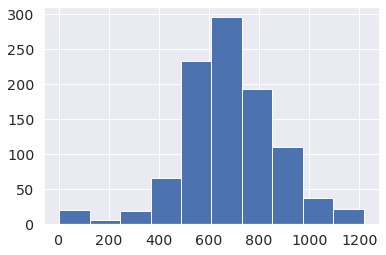

In [13]:
df_tp.drop_duplicates('ID').FIX_IN_VID.hist()

<AxesSubplot:>

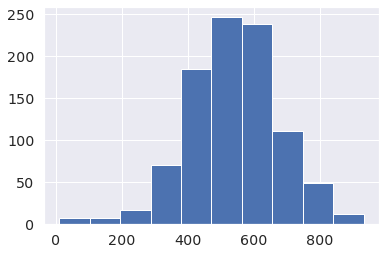

In [36]:
df_ff.drop_duplicates('ID').FIX_IN_VID.hist()

In [ ]:
df_tp.drop_duplicates('ID').FIX_IN_VID.hist()

In [23]:
subj = 'NDARDD128NWL'
data_path = os.path.join('..','data','ETFinalCutSampleEC07','ETFinalCutSample')
et_file   = os.path.join(data_path, subj, [f for f in os.listdir(os.path.join(data_path,subj)) if 'TP' in f][0])
df_et     = pd.read_csv(et_file)
df_fix, flag = preprocess_fixations(df_et, videos_data.loc['Present']['FramesTimestamps'], sdt_correction = False)

In [33]:
trial_resol_width=800
trial_resol_height=600

In [35]:
(df_fix.y.apply(max)>=trial_resol_height).sum()

0

In [29]:
trials_data = load_trials_data()

In [31]:
metadata

,Age,ID,Enroll_Season,Enroll_Year,Release_Number,Sex,CV_Score,med_type_01,med_type_02,med_type_03,...,Site,EHQ_Total,Child_Race,SWAN_HY,SWAN_IN,SWAN_Total,WAIS_FSIQ_SCALE,WASI_FSIQ,WISC_FSIQ,SWAN
0,6.728040,NDARAA075AMK,Summer,2016,1,1,14,NaN,NaN,NaN,...,2,65.54,NaN,-2.444444,-2.111111,-2.277777,.,.,140,-2.277777
1,5.545744,NDARAA112DMH,Fall,2016,1,0,14,NaN,NaN,NaN,...,1,40,2,.,.,.,.,.,.,NaN
2,7.475929,NDARAA117NEJ,Fall,2016,1,0,11,Non-Psychiatric Drug,NaN,NaN,...,1,62.2,2,0.555555,-1.111111,-0.277777,.,.,88,-0.277777
3,21.216746,NDARAA306NT2,Spring,2019,9,1,13,.,.,.,...,3,6.67,9,-1.666666,0,-0.833333,65,.,.,-0.833333
4,11.853296,NDARAA358BPN,Fall,2017,5,0,NaN,.,.,.,...,1,.,.,.,.,.,.,.,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4920,0.000000,.,.,.,.,.,.,NaN,NaN,NaN,...,.,.,.,.,.,.,.,.,.,NaN
4921,0.000000,.,.,.,.,.,.,NaN,NaN,NaN,...,.,.,.,.,.,.,.,.,.,NaN
4922,0.000000,.,.,.,.,.,.,NaN,NaN,NaN,...,.,.,.,.,.,.,.,.,.,NaN
4923,0.000000,.,.,.,.,.,.,NaN,NaN,NaN,...,.,.,.,.,.,.,.,.,.,NaN


In [9]:
int('Diary_of_a_Wimpy_Kid_Trailer-Scene-019-01.jpg'.split('-')[-2])

19

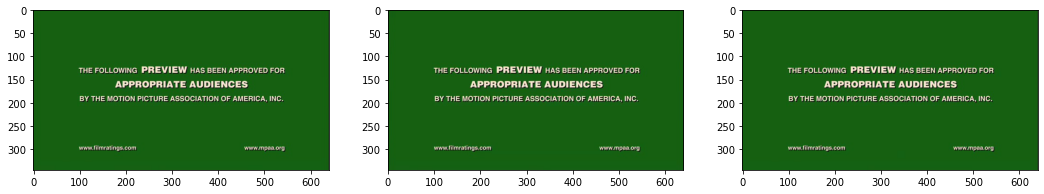

In [10]:
from scripts.utils import plot_sample_scenes
plot_sample_scenes(1,'Diary', '../videos_data/')

In [96]:
import os
import pandas as pd
from functools import reduce
from scripts.preprocessing import preprocess_fixations

def add_frame_idx(df,
                  vid_name,
                  videos_data,
                  etfile_path=None):
    
    dfs_list = []
    for idx in df.ID.unique():
    
        df_aux       = df[df.ID==idx].copy()
        et_file      = df_aux.ET_FILE.iloc[0]
        if etfile_path==None:
            df_et        = pd.read_csv(et_file)
        else:
            print('Not implemented')
        frame_timest = videos_data.loc[vid_name,'FramesTimestamps']
        #trial_init   = trials_data.loc[idx].set_index('VideoName').loc[vid_name].Start
        df_fix, flag = preprocess_fixations(df_et, frame_timest)
        frame_id     = df_fix.frames_seen.apply(lambda x: x[0])
        df_aux       = df_aux.merge(frame_id,how='right',left_on='FIX_idx',right_index=True)    
        dfs_list.append(df_aux)
        
    df_exploded_frames = pd.concat(dfs_list)
    df_exploded_frames.rename({'frames_seen':'FRAME_idx'}, axis=1, inplace=True)
    return df_exploded_frames

if __name__=='__main__':
    # join and save all results in the same dataframe
    data_path    = os.path.join('..','data','ETFinalCutSampleEC07','ETFinalCutSample')
    results_path  = os.path.join('..', 'results')
    
    vid_codes   = {'Diary': 'WK', 'Fractals': 'FF', 'Present': 'TP'}
    videos_data = load_video_data()
    
    df_dict = {'Diary':[], 'Present':[], 'Fractals':[]}
    for vid in df_dict.keys():
        path = os.path.join(results_path, vid_codes[vid])
        dfs = [pd.read_csv(os.path.join(path, 'results_nss_vinet.csv')).rename(columns={'NSS':'NSS_vn'}),
            pd.read_csv(os.path.join(path, 'results_nss_deepgazeii.csv'))[['ID','FIX_idx','NSS']].rename(columns={'NSS':'NSS_dg'}),
            pd.read_csv(os.path.join(path, 'results_nss_spectral.csv'))[['ID','FIX_idx','NSS']].rename(columns={'NSS':'NSS_sp'}),
            pd.read_csv(os.path.join(path, 'results_nss_finegrained.csv'))[['ID','FIX_idx','NSS']].rename(columns={'NSS':'NSS_fg'})]
    
        df_dict[vid] = reduce(lambda left,right: pd.merge(left,right,on=['ID', 'FIX_idx']), dfs).drop(columns='NSS_MEAN')
        print(f'Adding frame id in {vid}...')
        df_dict[vid] = add_frame_idx(df_dict[vid], vid, videos_data)
        print('Done')
        df_dict[vid].to_csv(os.path.join(results_path, vid_codes[vid] ,f'results_nss_{vid}.csv'.lower()), index=False)


Adding frame id in Diary...
Done
Adding frame id in Present...
Done
Adding frame id in Fractals...
Done


In [ ]:
NDARAA075AMK_Video-WK_ET_right.csv

## CORRS

In [90]:
def plot_corr_boxplots(df):
    
    df_corr = df.groupby('ID')[['NSS_dg', 'NSS_vn', 'NSS_fg', 'NSS_sp']].corr() 
    #df_corr = df.groupby('ID')[[ 'NSS_vn', 'NSS_fg']].corr() 
    fig, ax =  plt.subplots(figsize=(12,6))
    elem = []
    colors = iter(plt.cm.rainbow(np.linspace(0, 1, 10)))
    sal_combs = list(combinations(df_corr.index.levels[1].to_list(), r=2))
    for i, comb in enumerate(sal_combs):
        elem.append(ax.boxplot(df_corr.unstack()[comb], positions = [i], widths=0.4, patch_artist=True))
        
    #ax.legend([elem["boxes"][0] for elem in elem], comb)
    ax.set_xticklabels([str((x[0][-2:],x[1][-2:])) for x in sal_combs])

    return None

### WK

In [58]:
df_wk.columns, df_wk_old.columns

(Index(['ID', 'FIX_idx', 'NSS_vn', 'FIX_IN_VID', 'VIDEO_NAME', 'ET_FILE',
        'NSS_dg', 'NSS_sp', 'NSS_fg'],
       dtype='object'),
 Index(['ID', 'FIX_idx', 'NSS_vn', 'NSS_MEAN_vn', 'FIX_IN_VID', 'VIDEO_NAME',
        'ET_FILE', 'FRAME_idx', 'NSS_fg', 'NSS_MEAN_fg'],
       dtype='object'))

In [64]:
df_wk.shape, df_wk_old.shape, len(df_wk['ID'].unique()), len(df_wk_old['ID'].unique()) 

((690041, 9), (689665, 10), 1669, 1668)

In [67]:
set(df_wk.ID.unique())-set(df_wk_old.ID.unique())

{'NDARAL828WXM'}

In [77]:
aux = df_wk[df_wk.ID!='NDARAL828WXM']['NSS_vn'].reset_index()
(aux['NSS_vn'] - df_wk_old['NSS_vn']).sum()

0.0

In [78]:
aux = df_wk[df_wk.ID!='NDARAL828WXM']['NSS_fg'].reset_index()
(aux['NSS_fg'] - df_wk_old['NSS_fg']).sum()

-762.9970155628852

In [65]:
df_tp.shape, df_tp_old.shape, len(df_tp['ID'].unique()), len(df_tp_old['ID'].unique()) 

((684185, 9), (682521, 10), 1004, 1000)

In [86]:
df_tp.columns, df_tp_old.columns

(Index(['ID', 'FIX_idx', 'NSS_vn', 'FIX_IN_VID', 'VIDEO_NAME', 'ET_FILE',
        'NSS_dg', 'NSS_sp', 'NSS_fg'],
       dtype='object'),
 Index(['ID', 'FIX_idx', 'NSS_vn', 'NSS_MEAN_vn', 'FIX_IN_VID', 'VIDEO_NAME',
        'ET_FILE', 'FRAME_idx', 'NSS_fg', 'NSS_MEAN_fg'],
       dtype='object'))

In [80]:
list(set(df_tp.ID.unique())-set(df_tp_old.ID.unique()))

['NDARTP795WU2', 'NDARTP270UAV', 'NDARAN076TPG', 'NDARAL828WXM']

In [91]:
aux = df_tp[df_tp.ID.isin(list(set(df_tp.ID.unique())-set(df_tp_old.ID.unique())))]['NSS_vn'].reset_index()
(abs(aux['NSS_vn']) - abs(df_tp_old['NSS_vn'])).sum()

391.21906813423413

In [88]:
list(set(df_ff.ID.unique())-set(df_ff_old.ID.unique()))

['NDARFF644ZGD', 'NDARFR820KFF', 'NDARAL828WXM', 'NDARML024FF2']

In [ ]:
WK:
['NDARAL828WXM']
FF:
['NDARFF644ZGD', 'NDARFR820KFF', 'NDARAL828WXM', 'NDARML024FF2']
TP:
['NDARTP795WU2', 'NDARTP270UAV', 'NDARAN076TPG', 'NDARAL828WXM']

In [66]:
df_ff.shape, df_ff_old.shape, len(df_ff['ID'].unique()), len(df_ff_old['ID'].unique()) 

((506665, 9), (504922, 10), 944, 940)

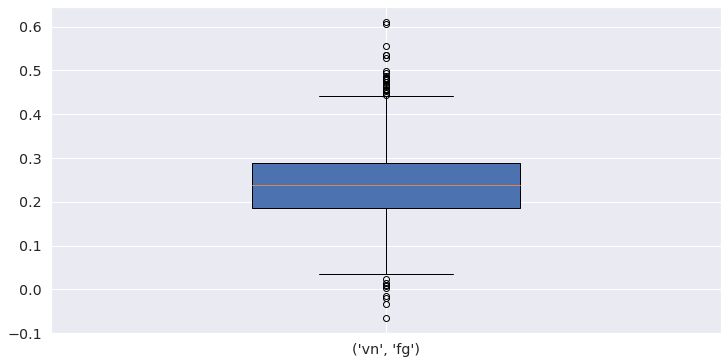

In [52]:
plot_corr_boxplots(df_ff)

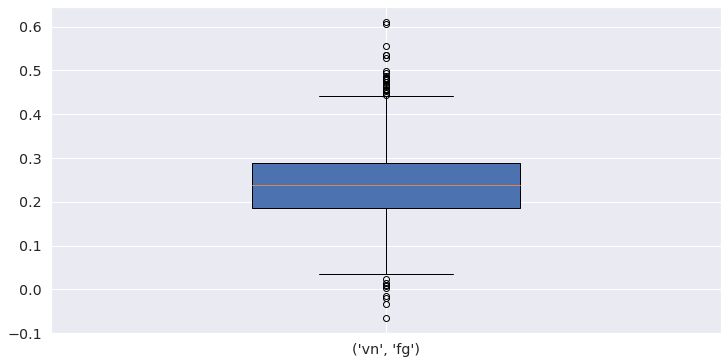

In [53]:
plot_corr_boxplots(df_ff_old)

In [14]:
df_wk = add_new_columns(df_wk, 'Diary', '', trials_data, videos_data)
df_tp = add_new_columns(df_tp, 'Present', '', trials_data, videos_data)
df_ff = add_new_columns(df_ff, 'Fractals', '', trials_data, videos_data)

In [15]:
df_wk.head()

,ID,FIX_idx,NSS_dg,FIX_IN_VID,VIDEO_NAME,ET_FILE,FRAME_idx,NSS_vn,NSS_fg,NSS_sp,x_mean,y_mean,start_time
0,NDARJH925ZCD,5,-0.293100,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,7,-0.100497,-0.396219,-0.414514,582.297273,440.065455,254.453
1,NDARJH925ZCD,7,0.255356,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,11,2.227505,0.889796,0.644614,470.131429,294.679286,454.385
2,NDARJH925ZCD,9,6.999779,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,17,2.251315,2.175435,2.470116,350.885000,294.072500,704.298
3,NDARJH925ZCD,11,2.229405,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,25,0.279915,0.435105,1.370525,278.265000,303.217500,1020.824
4,NDARJH925ZCD,13,0.908096,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,33,0.052687,1.367706,0.067163,263.296000,299.036000,1337.382


In [17]:
df_wk.drop(columns='FIX_IN_VID').to_csv(os.path.join(results_path, 'full_sabine', 'results_nss_wk_full.csv'), index=False)
df_tp.drop(columns='FIX_IN_VID').to_csv(os.path.join(results_path, 'full_sabine', 'results_nss_tp_full.csv'), index=False)
df_ff.drop(columns='FIX_IN_VID').to_csv(os.path.join(results_path, 'full_sabine', 'results_nss_ff_full.csv'), index=False)

# Scenes

In [18]:
saliency_models_nss = ['NSS_dg', 'NSS_vn', 'NSS_fg', 'NSS_sp']
palette =  dict(zip(saliency_models_nss, sns.color_palette(n_colors=4)))

In [20]:
wk_data = pd.read_csv('../videos_data/diary/Diary_of_a_Wimpy_Kid_Trailer-Scenes.csv', header=1)
tp_data = pd.read_csv('../videos_data/present/The Present_Short-Scenes.csv', header = 1)
ff_data = pd.read_csv('../videos_data/fractals/Fun_Fractals_v2-Scenes.csv', header = 1)

In [21]:
def calc_scenes(df, df_scenes):
    scenes_list = []
    for idx, row in df.iterrows():
        scene_idx = np.where((row.FRAME_idx >= df_scenes['Start Frame']) & (row.FRAME_idx < df_scenes['End Frame']))
        scenes_list.append(df_scenes.iloc[scene_idx]['Scene Number'])
    return scenes_list

In [22]:
scenes_tp = calc_scenes(df_tp, tp_data)
scenes_wk = calc_scenes(df_wk, wk_data)
scenes_ff = calc_scenes(df_ff, ff_data)

In [23]:
scenes_tp = list(map(lambda x: x.values[0], scenes_tp))
scenes_wk = list(map(lambda x: x.values[0], scenes_wk))
scenes_ff = list(map(lambda x: x.values[0], scenes_ff))

In [24]:
df_wk['Scenes'] = scenes_wk
df_tp['Scenes'] = scenes_tp
df_ff['Scenes'] = scenes_ff

In [25]:
df_wk.columns

Index(['ID', 'FIX_idx', 'NSS_dg', 'FIX_IN_VID', 'VIDEO_NAME', 'ET_FILE',
       'FRAME_idx', 'NSS_vn', 'NSS_fg', 'NSS_sp', 'x_mean', 'y_mean',
       'start_time', 'Scenes'],
      dtype='object')

## Aling beginning and end of scenes timeseries

In [26]:
wk_data.head()

,Scene Number,Start Frame,Start Timecode,Start Time (seconds),End Frame,End Timecode,End Time (seconds),Length (frames),Length (timecode),Length (seconds)
0,1,0,00:00:00.000,0.000,120,00:00:05.005,5.005,120,00:00:05.005,5.005
1,2,120,00:00:05.005,5.005,156,00:00:06.506,6.506,36,00:00:01.501,1.501
2,3,156,00:00:06.506,6.506,201,00:00:08.383,8.383,45,00:00:01.877,1.877
3,4,201,00:00:08.383,8.383,233,00:00:09.718,9.718,32,00:00:01.335,1.335
4,5,233,00:00:09.718,9.718,265,00:00:11.053,11.053,32,00:00:01.335,1.335


In [27]:
scenes_filtered_wk = wk_data[wk_data['Length (seconds)']>=3]
scenes_filtered_wk.shape

(5, 10)

In [28]:
df_wk.head()

,ID,FIX_idx,NSS_dg,FIX_IN_VID,VIDEO_NAME,ET_FILE,FRAME_idx,NSS_vn,NSS_fg,NSS_sp,x_mean,y_mean,start_time,Scenes
0,NDARJH925ZCD,5,-0.293100,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,7,-0.100497,-0.396219,-0.414514,582.297273,440.065455,254.453,1
1,NDARJH925ZCD,7,0.255356,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,11,2.227505,0.889796,0.644614,470.131429,294.679286,454.385,1
2,NDARJH925ZCD,9,6.999779,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,17,2.251315,2.175435,2.470116,350.885000,294.072500,704.298,1
3,NDARJH925ZCD,11,2.229405,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,25,0.279915,0.435105,1.370525,278.265000,303.217500,1020.824,1
4,NDARJH925ZCD,13,0.908096,545,Diary,./../data/ETFinalCutSampleEC07/ETFinalCutSampl...,33,0.052687,1.367706,0.067163,263.296000,299.036000,1337.382,1


In [29]:
def get_scenes_timeseries(df, df_data, nframes, min_lenght_seconds = 3, metric = 'NSS_dg'):
    """
    - df contains the nss data for each subject
    - df_data contains the scenes considered (Scene Number), the length in frames (Length (frames))
      as extracted from pyscenes
    
    """
    # dado que interpole hacia adelante tire los primeros frames por eso tiro la primera escena
    df_data = df_data.iloc[1:,:]
    
    # keep only scenes with a minimal lenght
    df_data = df_data[df_data['Length (seconds)']>=min_lenght_seconds]
    
    # mean timeseries
    timeseries = create_timeseries_matrix(df.reset_index(), metric_val=metric, nframes = nframes).dropna().mean(axis=1)
    
    # group by scenes and align to beginning (cut the rest)
    min_length_cut = df_data['Length (frames)'].min()
    print(min_length_cut)
    align_start = {}
    align_end   = {}
    
    for idx, row in df_data.iterrows():
        # check if there are subjects that saw the scene
        if int(row['Scene Number']) in df.Scenes.unique():
            align_start[row['Scene Number']] = timeseries.loc[row['Start Frame'] : row['Start Frame']+min_length_cut-1].to_list()
            align_end[row['Scene Number']]   = timeseries.loc[row['End Frame']-min_length_cut:row['End Frame']-1].to_list()

    print([len(align_start[s]) for s in align_start.keys()])
    print([len(align_end[s]) for s in align_end.keys()])
        
    try:
        align_start = pd.DataFrame(align_start)
        align_end   = pd.DataFrame(align_end)
        
    except ValueError:
        print('Hubo un ValueError')
        
    return align_start, align_end, timeseries

In [64]:
a, b, _ = get_scenes_timeseries(df_wk, wk_data, nframes = videos_data.loc['Diary','NFrames'].astype(int), metric='NSS_vn')

77
[77, 77, 77, 77]
[77, 77, 77, 77]


<AxesSubplot:>

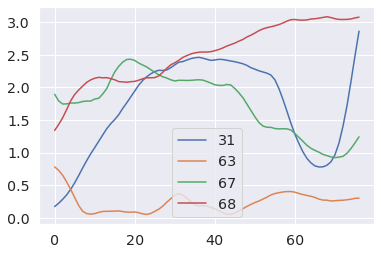

In [65]:
a.plot()

<AxesSubplot:>

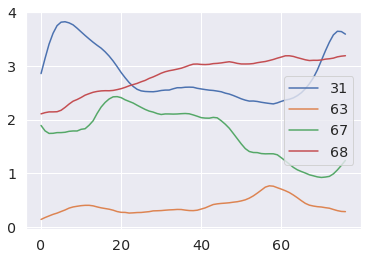

In [66]:
b.plot()

In [67]:
a, b, ts = get_scenes_timeseries(df_tp, tp_data, nframes = videos_data.loc['Present','NFrames'].astype(int), metric='NSS_vn')

72
[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]
[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]


<AxesSubplot:>

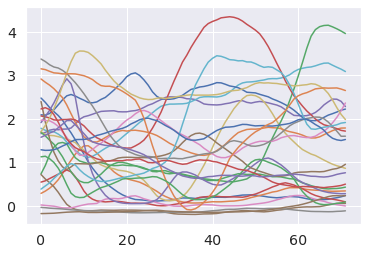

In [68]:
a.plot(legend=False)

<AxesSubplot:>

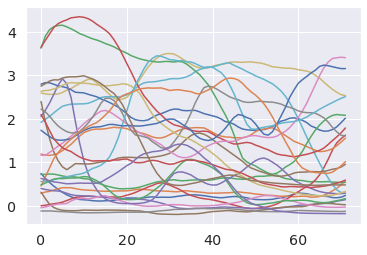

In [69]:
b.plot(legend=False)

In [70]:
a, b, ts = get_scenes_timeseries(df_ff, ff_data, nframes = videos_data.loc['Fractals','NFrames'].astype(int), metric='NSS_vn')

90
[90, 90, 90, 90, 90, 90, 90]
[90, 90, 90, 90, 90, 90, 90]


<AxesSubplot:>

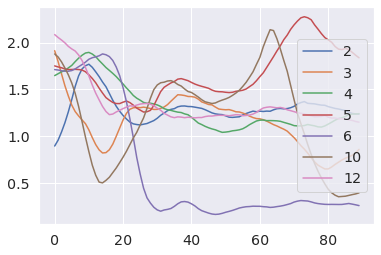

In [71]:
a.plot()

<AxesSubplot:>

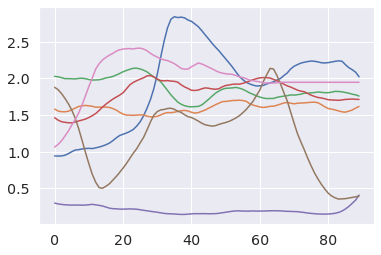

In [72]:
b.plot(legend=False)

IDEA:
Tener una funcion que le das una escena, y te grafique el promedio de la saliencia y la distribución de fijaciones o te muestree varios frames por segundo??

In [39]:
def plot_timeseries(timeseries, metric_name = 'NSS'):
    f, ax = plt.subplots(figsize=(15,9))
    m = timeseries.mean(axis=1)
    sm = timeseries.std(axis=1)
    plt.plot(m)
    plt.axhline(y = m.mean(), color = 'r', linestyle = '-.', alpha=0.7)
    plt.fill_between(m.index, m - 1 * sm, m + 1 * sm, alpha=0.2);
    ax.set_ylabel(metric_name, fontsize=15)
    #ax.legend('Frame', fontsize=14);
    #plt.title(video_full_name, fontsize=18);
    return None

In [40]:
def get_scenes_timeseries_erp(df, df_data, nframes, min_lenght_seconds = 3, metric = 'NSS_dg'):
    """
    - df contains the nss data for each subject
    - df_data contains the scenes considered (Scene Number), the length in frames (Length (frames))
      as extracted from pyscenes
    """
    # poner como variable
    do_plot = True
    
    # dado que interpole hacia adelante tire los primeros frames por eso tiro la primera escena
    df_data = df_data.iloc[1:,:]
    
    # keep only scenes with a minimal lenght
    df_data = df_data[df_data['Length (seconds)']>=min_lenght_seconds]
    
    # mean timeseries
    timeseries = create_timeseries_matrix(df.reset_index(), metric_val=metric, nframes = nframes).dropna()
    
    # group by scenes and align to beginning (cut the rest)
    min_length_cut = df_data['Length (frames)'].min()
    print(min_length_cut)
    align_start = {}
    align_end   = {}
    
    for idx, row in df_data.iterrows():
        # check if there are subjects that saw the scene
        if int(row['Scene Number']) in df.Scenes.unique():
            align_start[row['Scene Number']] = timeseries.loc[row['Start Frame']:row['Start Frame']+min_length_cut-1,:].reset_index(drop=True)
            align_end[row['Scene Number']]   = timeseries.loc[row['End Frame']-min_length_cut:row['End Frame']-1,:].reset_index(drop=True)

    print([len(align_start[s]) for s in align_start.keys()])
    print([len(align_end[s]) for s in align_end.keys()])
        
    try:
        align_start = pd.concat(align_start)
        align_end   = pd.concat(align_end)
        
        if do_plot:
            f, ax = plt.subplots(1,2,figsize=(16,8),sharey=True)
            m = align_start.reset_index().drop(columns =['level_0']).groupby('level_1').mean().mean(axis=1)
            sm = align_start.reset_index().drop(columns =['level_0']).groupby('level_1').mean().sem(axis=1)
            ax[0].plot(m)
            ax[0].fill_between(m.index, m - 1 * sm, m + 1 * sm, alpha=0.2);
            
            #plt.axhline(y = m.mean(), color = 'r', linestyle = '-.', alpha=0.7)
            
            m = align_end.reset_index().drop(columns =['level_0']).groupby('level_1').mean().mean(axis=1)
            sm = align_end.reset_index().drop(columns =['level_0']).groupby('level_1').mean().sem(axis=1)
            ax[1].plot(m)
            ax[1].fill_between(m.index, m - 1 * sm, m + 1 * sm, alpha=0.2);
            
            ax[0].set_ylabel(metric, fontsize=15)
            ax[0].set_xlabel('Start aligned')
            ax[1].set_xlabel('End aligned')
        
    except ValueError:
        print('Hubo un ValueError')
        
    return align_start, align_end, timeseries

77
[77, 77, 77, 77]
[77, 77, 77, 77]


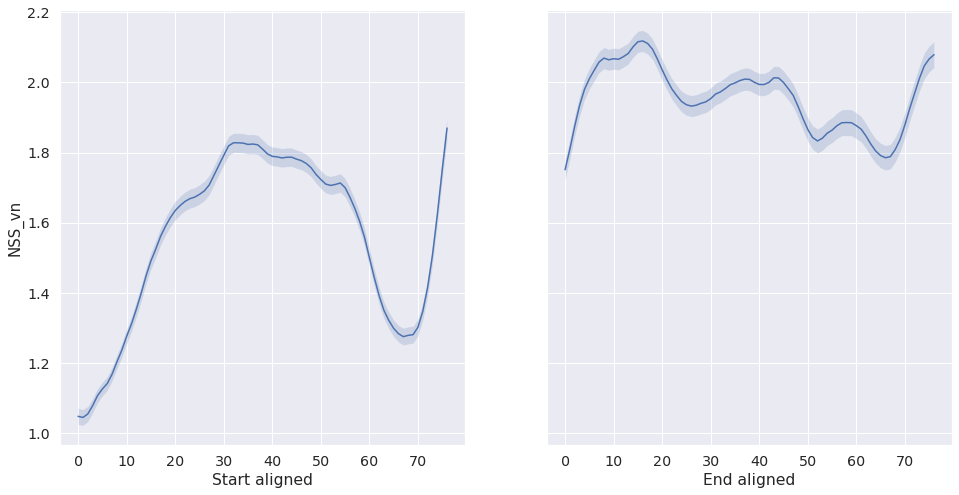

In [41]:
a, b, _ = get_scenes_timeseries_erp(df_wk, wk_data, nframes = videos_data.loc['Diary','NFrames'].astype(int), metric='NSS_vn')

72
[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]
[72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72]


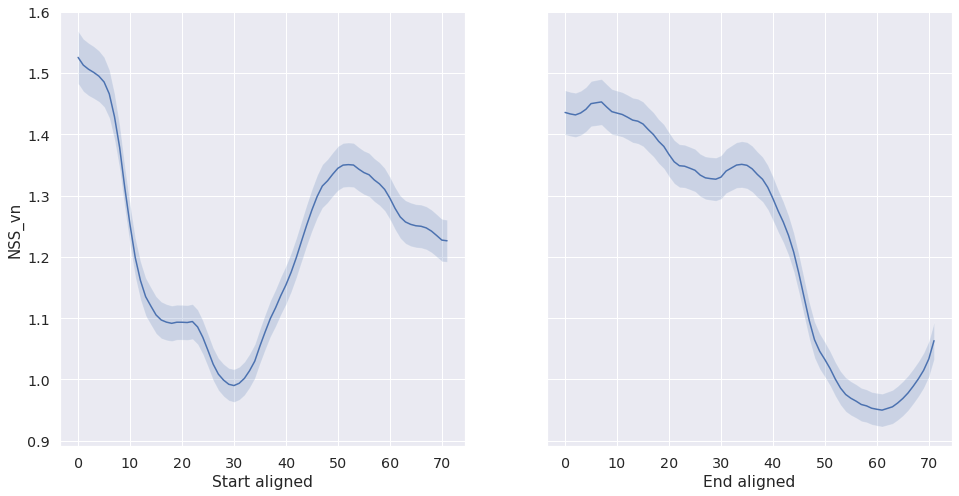

In [42]:
a, b, _ = get_scenes_timeseries_erp(df_tp, tp_data, nframes = videos_data.loc['Present','NFrames'].astype(int), metric = 'NSS_vn')

90
[90, 90, 90, 90, 90, 90, 90]
[90, 90, 90, 90, 90, 90, 90]


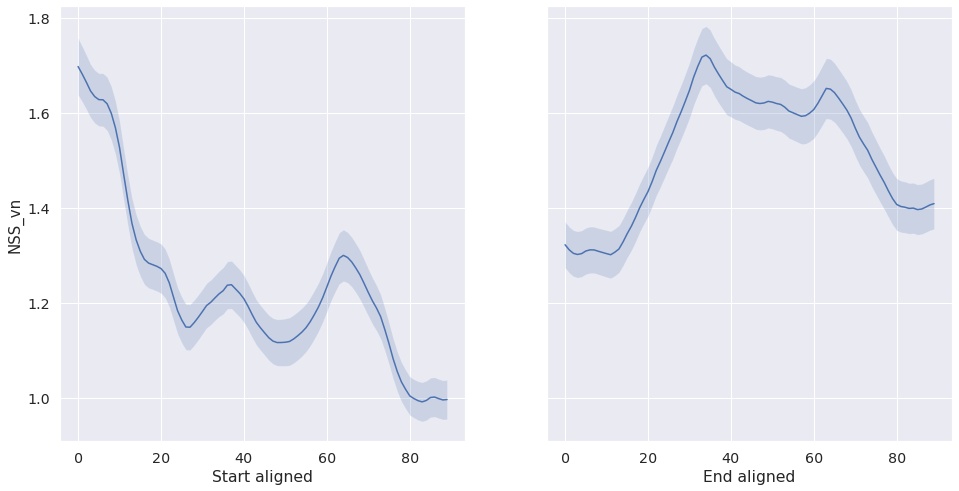

In [43]:
a, b, _ = get_scenes_timeseries_erp(df_ff, ff_data, nframes = videos_data.loc['Fractals','NFrames'].astype(int), metric = 'NSS_vn')

## Cross correlations?

# Objects

In [44]:
def calc_scenes(df, df_scenes,colname='frame'):
    scenes_list = []
    for idx, row in df.iterrows():
        scene_idx = np.where((row[colname] >= df_scenes['Start Frame']) & (row[colname] < df_scenes['End Frame']))
        scenes_list.append(df_scenes.iloc[scene_idx]['Scene Number'].iloc[0])
    return scenes_list

In [45]:
annotationsWK = pd.read_csv(os.path.join('..','videos_data', 'annotationsWK.csv'))
annotationsWK.columns = ['frame', 'object']
annotationsWK['frame'] = annotationsWK['frame']-1
annotationsWK['scene'] = calc_scenes(annotationsWK, wk_data)
annotationsWK['object'] = annotationsWK['object'].apply(lambda x: x.rstrip().lstrip())

annotationsTP = pd.read_csv(os.path.join('..','videos_data', 'annotationsTP.csv'))
annotationsTP.columns = ['frame', 'object']
annotationsTP['frame'] = annotationsTP['frame']-1
annotationsTP['scene'] = calc_scenes(annotationsTP, tp_data)
annotationsTP['object'] = annotationsTP['object'].apply(lambda x: x.rstrip().lstrip())

annotationsFF = pd.read_csv(os.path.join('..','videos_data', 'annotationsFF.csv'))
annotationsFF.columns = ['frame', 'object']
annotationsFF['frame']  = annotationsFF['frame']-1
annotationsFF['scene']  = calc_scenes(annotationsFF, ff_data)
annotationsFF['object'] = annotationsFF['object'].apply(lambda x: x.rstrip().lstrip())

In [46]:
annotationsTP.object.value_counts()#['scene'].iloc[0][0]

Object    12100
Person     4694
Dog        2384
Text        240
Name: object, dtype: int64

In [47]:
annotationsTP.object.unique()

array(['Person', 'Object', 'Text', 'Dog'], dtype=object)

In [48]:
annotationsWK = pd.get_dummies(annotationsWK, columns = ['object']).groupby('frame').sum().drop(columns = 'scene')
annotationsTP = pd.get_dummies(annotationsTP, columns = ['object']).groupby('frame').sum().drop(columns = 'scene')
annotationsFF = pd.get_dummies(annotationsFF, columns = ['object']).groupby('frame').sum().drop(columns = 'scene')

In [50]:
def annotations_nss_corr(df, nframes, annotations, metric = 'NSS_dg'):
    timeseries = create_timeseries_matrix(df.reset_index(), metric_val=metric, nframes = nframes).dropna()
    ts = timeseries.dropna().mean(axis=1).rename(metric)
    
    # add by scene
    
    return annotations.join(ts, how='inner').corr().iloc[-1,:]

In [51]:
annotations_nss_corr(df_wk, videos_data.loc['Diary','NFrames'].astype(int), annotationsWK)

object_Face     -0.243606
object_Object    0.005754
object_Person   -0.175190
object_Text      0.118060
NSS_dg           1.000000
Name: NSS_dg, dtype: float64

In [52]:
annotations_nss_corr(df_wk, videos_data.loc['Diary','NFrames'].astype(int), annotationsWK, metric='NSS_vn')

object_Face     -0.269604
object_Object    0.068189
object_Person   -0.151367
object_Text      0.084752
NSS_vn           1.000000
Name: NSS_vn, dtype: float64

In [53]:
annotations_nss_corr(df_tp, videos_data.loc['Present','NFrames'].astype(int), annotationsTP)

object_Dog       0.195855
object_Object   -0.027750
object_Person   -0.187833
object_Text     -0.035019
NSS_dg           1.000000
Name: NSS_dg, dtype: float64

In [54]:
annotations_nss_corr(df_tp, videos_data.loc['Present','NFrames'].astype(int), annotationsTP, metric='NSS_vn')

object_Dog       0.263150
object_Object   -0.138490
object_Person   -0.307745
object_Text      0.010023
NSS_vn           1.000000
Name: NSS_vn, dtype: float64

In [55]:
annotations_nss_corr(df_ff, videos_data.loc['Fractals','NFrames'].astype(int), annotationsFF)

object_Object    0.335986
object_Text     -0.289111
NSS_dg           1.000000
Name: NSS_dg, dtype: float64

In [56]:
annotations_nss_corr(df_ff, videos_data.loc['Fractals','NFrames'].astype(int), annotationsFF, metric='NSS_vn')

object_Object    0.201401
object_Text     -0.111285
NSS_vn           1.000000
Name: NSS_vn, dtype: float64

# OLD

## Calculations

In [31]:
df_wk.groupby(['ID', 'Scenes'])[saliency_models_nss].mean().unstack(level=0)

NSS_dg                                                      \
ID     NDARAA075AMK NDARAA117NEJ NDARAA948VFH NDARAC349YUC NDARAC350XUM   
Scenes                                                                    
1          1.097726     1.037964     1.378386     1.127329     0.482119   
2          1.391617     0.445252     1.431405     1.093518          NaN   
3          0.331094     1.289026     1.655309     1.179105          NaN   
4          1.723844     0.425321     1.176409     1.321408          NaN   
5          2.349400     0.533069     2.677721     1.478582          NaN   
...             ...          ...          ...          ...          ...   
66         4.718161     4.907912     5.237440     3.712873     6.939557   
67         2.519720     2.760290     1.512639     2.630684     1.948843   
68         3.417428     2.997991     5.854970     3.834726     2.355282   
69         3.314532     1.368650     2.777891     1.586873     2.363588   
70         0.958587     1.125802     3.045257     2.003370          NaN   

                                                                         ...  \
ID     NDARAC853DTE NDARAC904DMU NDARAD481FXF NDARAD774HAZ NDARAE012DGA  ...   
Scenes                                                                   ...   
1         -0.337040     2.274569     1.133934     1.516540     1.697699  ...   
2         -0.077192     2.783401     0.890490     2.477942     1.096856  ...   
3          1.521194     1.514500     0.875381     1.036723     1.071927  ...   
4          0.559340     0.655556     1.276918     1.697053     1.335259  ...   
5          0.456748     1.682983     1.509835     0.729283     1.117308  ...   
...             ...          ...          ...          ...          ...  ...   
66        -0.038945     6.247863     0.883035     6.416334     3.968389  ...   
67         0.344725     2.153297     3.388674     2.233393     2.599456  ...   
68         1.029636     4.752084     3.684000     2.371341     3.685138  ...   
69         0.221471     2.717924     0.653435     1.109885     2.151199  ...   
70         1.168540     2.235009     3.566559     1.910893     1.100249  ...   

             NSS_sp                                                      \
ID     NDARZR412TBP NDARZT772PU4 NDARZU822WN3 NDARZV766YXP NDARZV895RZ5   
Scenes                                                                    
1          0.830724     0.963719     1.264310     1.643036     0.583555   
2         -0.049490    -0.049490    -0.049490    -0.232861    -0.049490   
3         -0.322078    -0.542641    -0.696002     0.143120    -0.378199   
4          0.218568    -0.275307    -0.513473     0.292762    -0.325194   
5         -0.126863    -0.248657    -0.595054     0.060426    -0.242644   
...             ...          ...          ...          ...          ...   
66        -0.369913    -0.436035     0.291088     1.376594     0.823033   
67         0.432141     0.467002          NaN     0.305866     0.028037   
68         3.018089     0.599662     0.850482     0.747237     1.851744   
69         1.316713     1.081517     2.869309     0.728690     1.000302   
70        -0.049490          NaN          NaN          NaN    -0.049490   

                                                                         
ID     NDARZW013RUH NDARZW873DN3 NDARZX561DR9 NDARZY101JNB NDARZZ007YMP  
Scenes                                                                   
1         -0.324392     0.402424     1.627709     0.665347     0.185039  
2               NaN          NaN     0.598222          NaN    -0.049490  
3               NaN          NaN    -0.666615          NaN    -0.410334  
4               NaN          NaN    -0.065873    -0.573989    -0.265323  
5               NaN          NaN    -0.590822    -0.480077    -0.246011  
...             ...          ...          ...          ...          ...  
66         0.498843     0.759606    -0.154940     0.014210     0.790141  
67         0.609722    -0.045829     0.151765     

In [34]:
df_wk.groupby(['ID', 'Scenes'])[saliency_models_nss]

In [33]:
def calculate_nss_scenes(df, scenes_data, saliency_models = saliency_models_nss):
    nss_scenes = []
    nss_scenes_err = []
    for sal in saliency_models_nss:
        nss_scenes.append(df.groupby(['ID', 'Scenes'])[saliency_models].mean().unstack(level=0)[sal].mean(axis=1))
        nss_scenes_err.append(df.groupby(['ID', 'Scenes'])[saliency_models].mean().unstack(level=0)[sal].sem(axis=1))

    nss_scenes = pd.DataFrame(nss_scenes).T
    nss_scenes.columns = saliency_models
    nss_scenes_err = pd.DataFrame(nss_scenes_err).T
    nss_scenes_err.columns = saliency_models
    
    
    time_index = (pd.to_timedelta(scenes_data['Start Timecode']) + pd.to_timedelta(scenes_data['Length (timecode)'])/2).dt.total_seconds()
    time_index.name = 'scene_time'
    nss_scenes_toplot = nss_scenes.reset_index(drop=True)
    
    nss_scenes_toplot = nss_scenes_toplot.join(time_index).set_index('scene_time')
    nss_scenes_toplot_err = nss_scenes_err.reset_index(drop=True).join(time_index).set_index('scene_time')
    
    fig, ax = plt.subplots(figsize=(18,7))
    nss_scenes_toplot.plot(ax=ax, yerr=nss_scenes_toplot_err)
    ax.set_xlabel('Time (s)')
    
    a = pd.melt(nss_scenes.reset_index(), id_vars=['Scenes'],
        value_vars=saliency_models_nss, var_name='saliency_type', value_name='nss_value')
    b = pd.melt(nss_scenes_err.reset_index(), id_vars=['Scenes'],
        value_vars=saliency_models_nss, var_name='saliency_type', value_name='nss_value')
    return pd.merge(a,b, left_on=['Scenes','saliency_type'], right_on=['Scenes','saliency_type'], how = 'outer', suffixes=('','_err'))

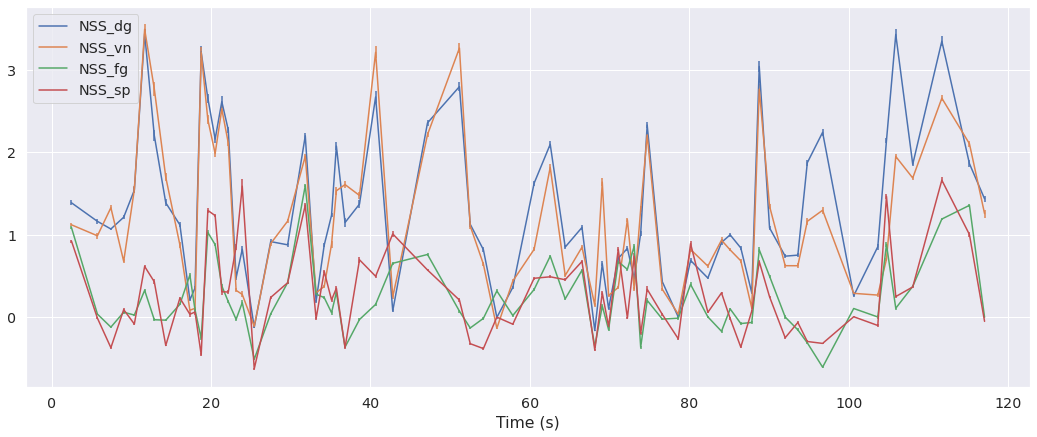

In [34]:
_ = calculate_nss_scenes(df_wk, scenes_data=wk_data)

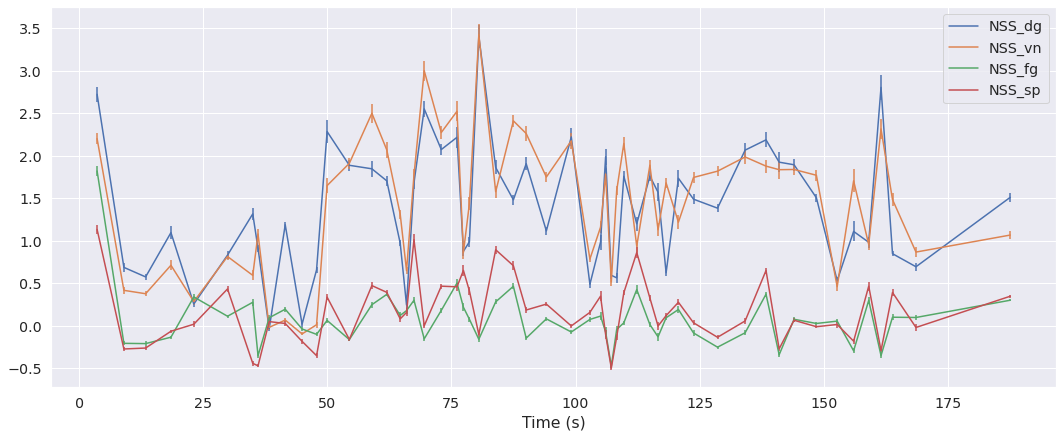

In [76]:
_ = calculate_nss_scenes(df_tp, tp_data)

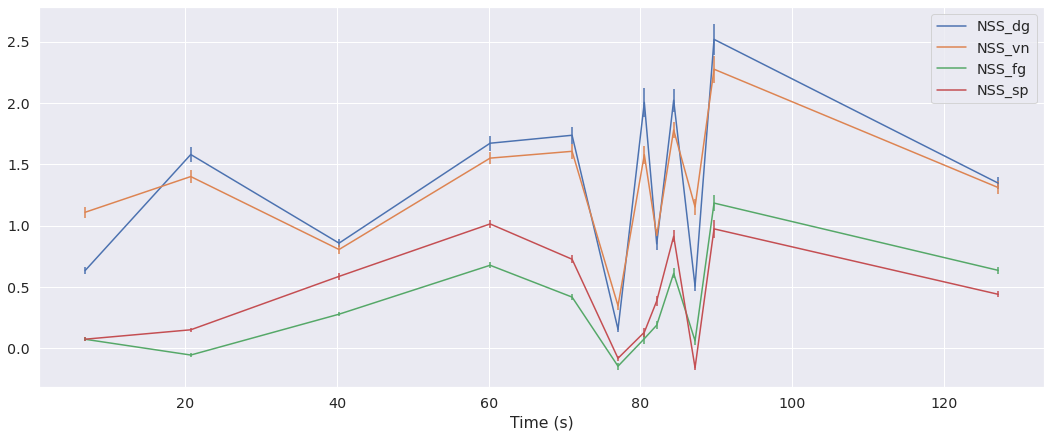

In [77]:
_ = calculate_nss_scenes(df_ff, ff_data)

## Correlations with scene length
Ojo que en los df hay nans!!

In [78]:
from scipy.stats import pearsonr

In [79]:
# https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    dfcorr = dfcols.transpose().join(dfcols, how='outer')
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            dfcorr[r][c] = round(pearsonr(df[r], df[c])[0], 4)
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return dfcorr, pvalues

In [80]:
def calculate_scenes_corrs(df, scenes_data, saliency_models, do_plot=True):
    mean_nss = []
    for sal in saliency_models:
        scenes_nss = df.groupby(['ID', 'Scenes'])[saliency_models_nss].mean().unstack(level=0)[sal]
        scenes_nss = scenes_nss.mean(axis=1)
        scenes_nss.name = sal
        mean_nss.append(scenes_nss)
    
    nss_vals_scenes = pd.concat(mean_nss,axis=1).join(scenes_data[['Scene Number','Length (seconds)']].set_index('Scene Number'))
    
    
    ret = pd.melt(nss_vals_scenes, id_vars='Length (seconds)',var_name='saliency', value_name='NSS')
    if do_plot:
        fig, ax = plt.subplots(figsize=(10,7))
        sns.scatterplot(x = 'Length (seconds)', y ='NSS', hue='saliency', data= ret, ax=ax, palette=palette)
    
    corrs = calculate_pvalues(nss_vals_scenes)
    out   = pd.concat([corrs[0].iloc[:-1,-1], corrs[1].iloc[:-1,-1]],axis=1)
    out.columns = [out.columns[0] + ' - corr', out.columns[0] + ' - pval']
    return out

In [81]:
calculate_scenes_corrs(df_wk, wk_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.0404,0.7397
NSS_vn,0.0362,0.7663
NSS_fg,0.2456,0.0404
NSS_sp,0.1436,0.2358


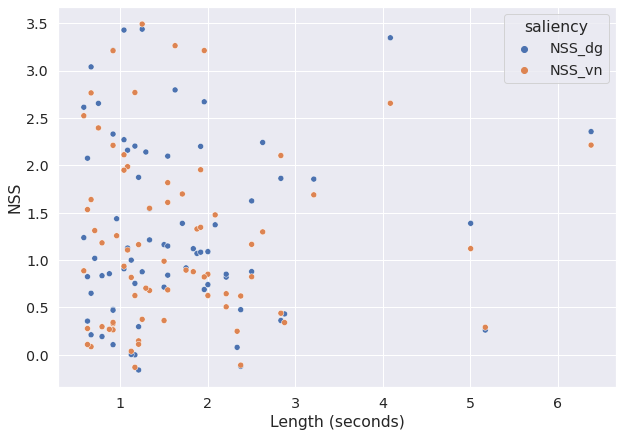

In [82]:
_ = calculate_scenes_corrs(df_wk, wk_data, ['NSS_dg', 'NSS_vn'])

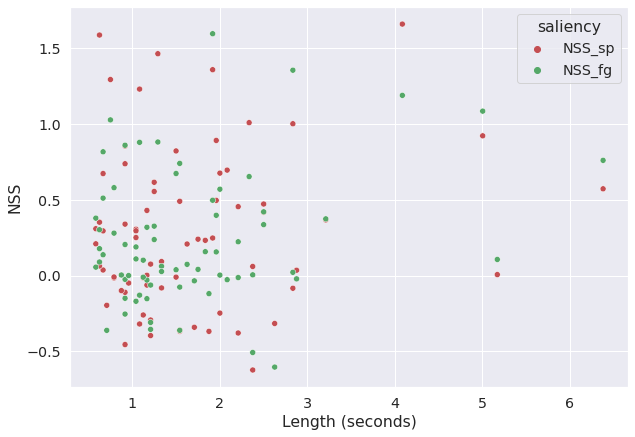

In [83]:
_ = calculate_scenes_corrs(df_wk, wk_data, ['NSS_sp', 'NSS_fg'])

In [84]:
calculate_scenes_corrs(df_tp, tp_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.0314,0.8202
NSS_vn,-0.0689,0.6172
NSS_fg,0.1791,0.1908
NSS_sp,0.1235,0.3691


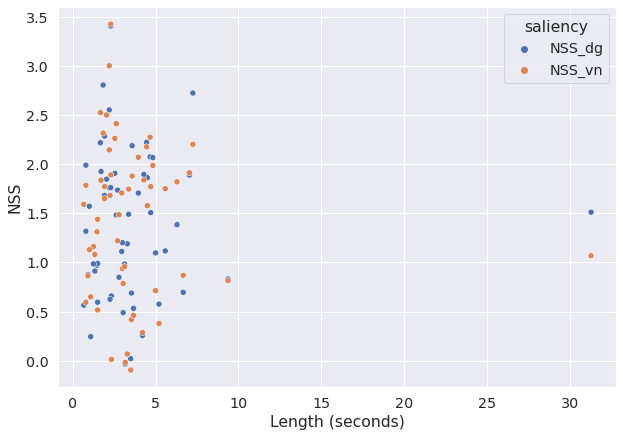

In [85]:
_ = calculate_scenes_corrs(df_tp, tp_data, ['NSS_dg', 'NSS_vn'])

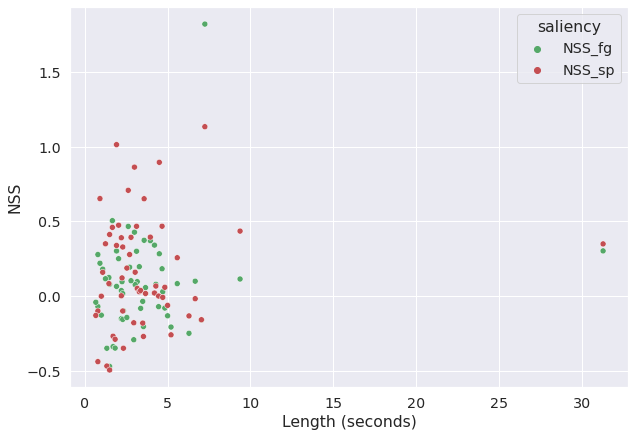

In [86]:
_ = calculate_scenes_corrs(df_tp, tp_data, ['NSS_fg', 'NSS_sp'])

In [87]:
calculate_scenes_corrs(df_ff, ff_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,-0.0771,0.8117
NSS_vn,-0.116,0.7196
NSS_fg,0.184,0.567
NSS_sp,0.0423,0.8961


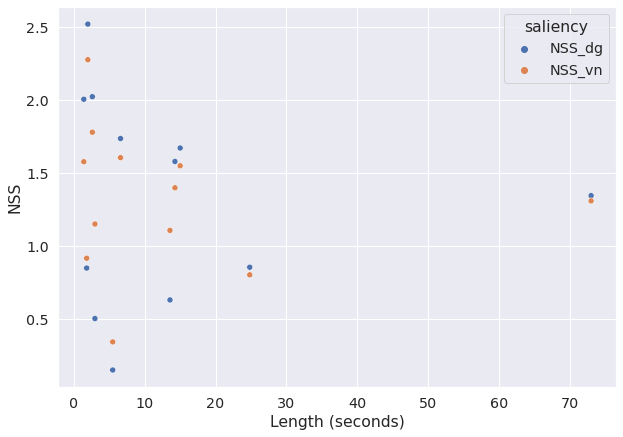

In [88]:
_ = calculate_scenes_corrs(df_ff, ff_data, ['NSS_dg', 'NSS_vn'])

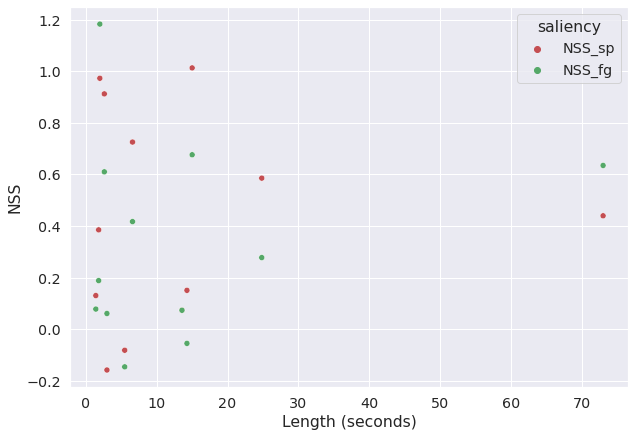

In [89]:
_ = calculate_scenes_corrs(df_ff, ff_data, ['NSS_sp', 'NSS_fg'])

### Dispersion acording scene length

In [91]:
def calculate_scenes_mean_dispersion(df, scenes_data, saliency_models, do_plot=True):
    mean_std_nss = []
    std_std_nss  = []
    for sal in saliency_models:
        scenes_nss = df.groupby(['ID', 'Scenes'])[saliency_models_nss].std().unstack(level=0)[sal]
        # mean value of fixations for each scene for each subject
        scenes_nss_mean_std = scenes_nss.mean(axis=1)
        scenes_nss_std_std  = scenes_nss.std(axis=1)
        scenes_nss_mean_std.name = sal
        mean_std_nss.append(scenes_nss_mean_std)
        scenes_nss_std_std.name = sal
        std_std_nss.append(scenes_nss_mean_std)
        
    nss_vals_scenes = pd.concat(mean_std_nss,axis=1).join(scenes_data[['Scene Number','Length (seconds)']].set_index('Scene Number'))
#     nss_vals_scenes = nss_vals_scenes.join(pd.concat(std_std_nss,axis=1), rsuffix = '_std')#[['Scene Number','Length (seconds)']].set_index('Scene Number'))
    nss_vals_scenes.reset_index(inplace=True)
    
    ret = pd.melt(nss_vals_scenes, 
                  value_vars = saliency_models,
                  id_vars = ['Scenes', 'Length (seconds)'], 
                  var_name = 'saliency',
                  value_name = 'NSS_std')
    
#     ret = pd.melt(ret, 
#                   value_vars = [s + '_std' for s in saliency_models],
#                   id_vars = ['Scenes','Length (seconds)','saliency', 'NSS_std'], 
#                   var_name = 'saliency_std',
#                   value_name = 'NSS_disp')

    #     ret = pd.melt(nss_vals_scenes, id_vars='Length (seconds)',var_name='saliency', value_name='NSS')
    if do_plot:
        fig, ax = plt.subplots(figsize=(10,7))
        sns.scatterplot(x = 'Length (seconds)', y ='NSS_std', hue='saliency', data= ret, ax=ax, palette=palette)
    
    corrs = calculate_pvalues(nss_vals_scenes)
    out   = pd.concat([corrs[0].iloc[1:-1,-1], corrs[1].iloc[1:-1,-1]],axis=1)
    out.columns = [out.columns[0] + ' - corr', out.columns[0] + ' - pval']
    return out
#     return ret

In [92]:
calculate_scenes_mean_dispersion(df_wk, wk_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.3163,0.0076
NSS_vn,0.2582,0.0309
NSS_fg,0.4336,0.0002
NSS_sp,0.3148,0.008


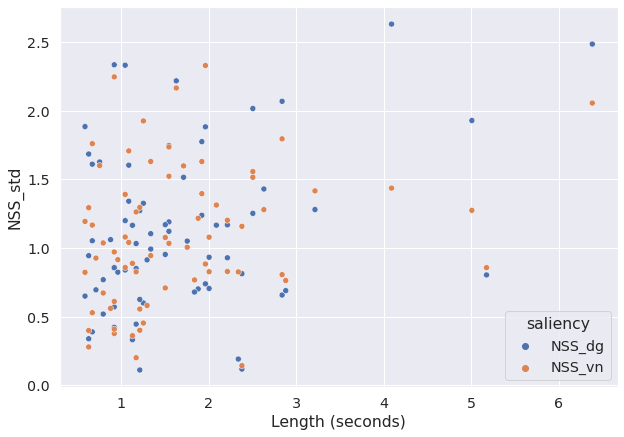

In [93]:
_ = calculate_scenes_mean_dispersion(df_wk, wk_data, ['NSS_dg', 'NSS_vn'])

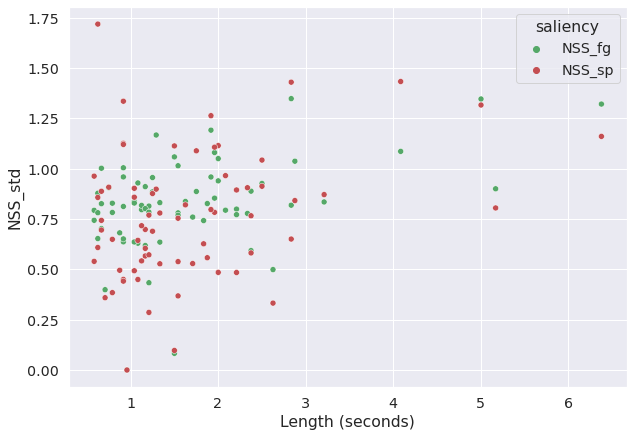

In [94]:
_ = calculate_scenes_mean_dispersion(df_wk, wk_data, ['NSS_fg', 'NSS_sp'])

In [95]:
calculate_scenes_mean_dispersion(df_tp, tp_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.3272,0.0147
NSS_vn,0.3796,0.0043
NSS_fg,0.2768,0.0408
NSS_sp,0.2129,0.1186


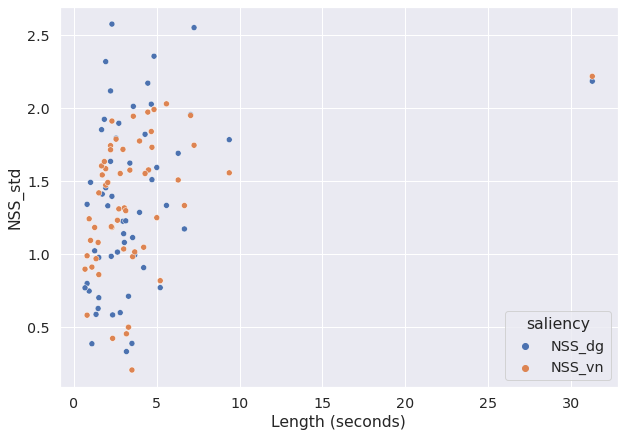

In [96]:
_ = calculate_scenes_mean_dispersion(df_tp, tp_data, ['NSS_dg', 'NSS_vn'])

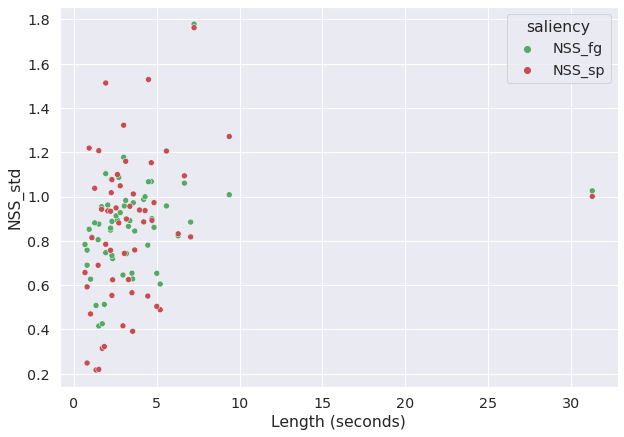

In [97]:
_ = calculate_scenes_mean_dispersion(df_tp, tp_data, ['NSS_fg', 'NSS_sp'])

In [98]:
calculate_scenes_mean_dispersion(df_ff, ff_data, saliency_models_nss, do_plot=False)

,Length (seconds) - corr,Length (seconds) - pval
NSS_dg,0.2329,0.4664
NSS_vn,0.4326,0.1601
NSS_fg,-0.0715,0.8252
NSS_sp,0.383,0.2191


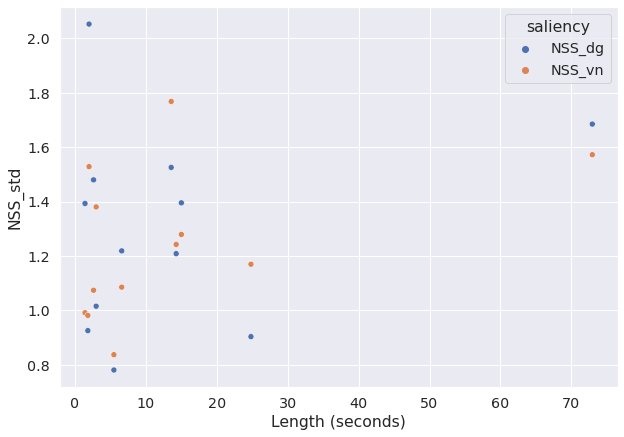

In [99]:
_ = calculate_scenes_mean_dispersion(df_ff, ff_data, ['NSS_dg', 'NSS_vn'])

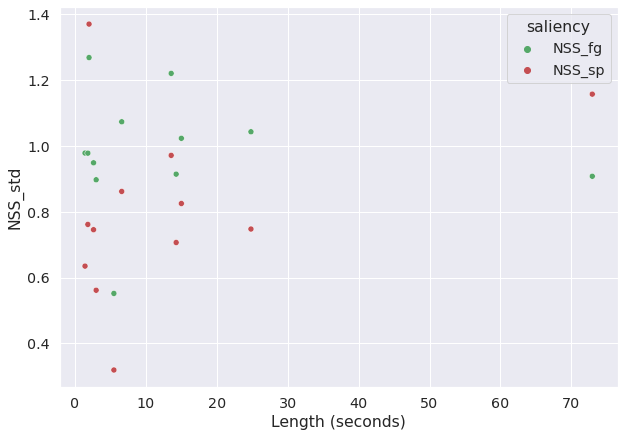

In [100]:
_ = calculate_scenes_mean_dispersion(df_ff, ff_data, ['NSS_fg', 'NSS_sp'])

## Scenes entropy

### Entropy cals - RUN ONLY ONCE

In [102]:
from skimage.filters.rank import entropy
from skimage.io import imread
from skimage.morphology import disk
import json

In [465]:
saliency_path = '../videos_sal/'
saliency_fold = 'deepgazeii'

In [476]:
entropy_vals = {'Diary':[], 'Fractals':[], 'Present':[]}
for vid, vid_fold in videos_data.iloc[:3,0].iteritems():
    vid_fold = vid_fold[:-4]
    path = os.path.join(saliency_path, saliency_fold, vid_fold)
    for img_file in sorted(os.listdir(path)):
        img= imread(os.path.join(path,img_file), as_gray=True)
        entropy_vals[vid].append(entropy(img, disk(5)).mean())
    print('Done: ',vid)

In [481]:
with open(os.path.join(saliency_path, saliency_fold, 'entropy_vals.json'), 'w') as fp:
    json.dump(entropy_vals, fp)

In [484]:
saliency_fold = 'vinet'
entropy_vals_vn = {'Diary':[], 'Fractals':[], 'Present':[]}
for vid, vid_fold in videos_data.iloc[:3,0].iteritems():
    vid_fold = vid_fold[:-4]
    path = os.path.join(saliency_path, saliency_fold, vid_fold)
    for img_file in sorted(os.listdir(path)):
        try:
            img= imread(os.path.join(path,img_file), as_gray=True)
        except:
            print(os.path.join(path,img_file))
        entropy_vals_vn[vid].append(entropy(img, disk(5)).mean())
    print('Done: ',vid)

../videos_sal/vinet/Diary_of_a_Wimpy_Kid_Trailer/.ipynb_checkpoints
Done:  Diary
Done:  Fractals
Done:  Present


In [485]:
with open(os.path.join(saliency_path, saliency_fold, 'entropy_vals.json'), 'w') as fp:
    json.dump(entropy_vals_vn, fp)

In [486]:
saliency_fold = 'finegrained'
entropy_vals_fg = {'Diary':[], 'Fractals':[], 'Present':[]}
for vid, vid_fold in videos_data.iloc[:3,0].iteritems():
    vid_fold = vid_fold[:-4]
    path = os.path.join(saliency_path, saliency_fold, vid_fold)
    for img_file in sorted(os.listdir(path)):
        try:
            img= imread(os.path.join(path,img_file), as_gray=True)
        except:
            print(os.path.join(path,img_file))
        entropy_vals_fg[vid].append(entropy(img, disk(5)).mean())
    print('Done: ',vid)

../videos_sal/finegrained/Diary_of_a_Wimpy_Kid_Trailer/.ipynb_checkpoints
Done:  Diary
Done:  Fractals
Done:  Present


In [487]:
with open(os.path.join(saliency_path, saliency_fold, 'entropy_vals.json'), 'w') as fp:
    json.dump(entropy_vals_fg, fp)

### Load entropy

In [103]:
saliency_path = '../videos_sal/'

In [108]:
saliency_fold = 'deepgazeii'
with open(os.path.join(saliency_path, saliency_fold,'entropy_vals.json')) as json_file:
    dg_entropy = json.load(json_file)

saliency_fold = 'finegrained'
with open(os.path.join(saliency_path, saliency_fold,'entropy_vals.json')) as json_file:
    fg_entropy = json.load(json_file)

saliency_fold = 'spectral'
with open(os.path.join(saliency_path, saliency_fold,'entropy_vals.json')) as json_file:
    sp_entropy = json.load(json_file)

saliency_fold = 'vinet'
with open(os.path.join(saliency_path, saliency_fold,'entropy_vals.json')) as json_file:
    vn_entropy = json.load(json_file)

In [109]:
sal_dict = dict(zip(saliency_models_nss,[dg_entropy, vn_entropy, fg_entropy, sp_entropy]))

ent = []
for vid in videos_data.iloc[:3,0].index:
    ent_vid = []
    for sal in sal_dict.keys():
        sal_vid_ent = sal_dict[sal][vid]
        ent_vid.append(sal_vid_ent)
    df = pd.DataFrame(ent_vid).T
    df.columns = saliency_models_nss
    ent.append(df)
ent = dict(zip(videos_data.iloc[:3,0].index, ent))

In [110]:
scene_vid = dict(zip(videos_data.iloc[:3,0].index,[wk_data,ff_data,tp_data]))
for vid in scene_vid.keys():
    ent[vid]['FRAME_idx'] = ent[vid].index
    aux = calc_scenes(ent[vid], scene_vid[vid])
    aux = pd.DataFrame([a.values for a in aux], columns = ['Scenes']).fillna(scene_vid[vid]['Scene Number'].iloc[-1])
    aux['Scenes'] = aux['Scenes'].astype(int)
    ent[vid] = ent[vid].join(aux)#.drop(columns=['FRAME_idx'])
    ent[vid] = ent[vid].groupby('Scenes').mean()

### Correlation NSS with entropy per scene

In [145]:
dg_entropy['Present'][500]

0.5267457415058924

In [148]:
vn_entropy['Present'][500]

0.4649167053942976

In [147]:
sp_entropy['Present'][500]

1.2527462321725449

In [149]:
fg_entropy['Present'][500]

3.2436439612989205

In [153]:
def calculate_scenes_corrs_entropy(df, df_entropy, scenes_data, saliency_models,var='mean'):
    mean_nss = []
    n = len(saliency_models)
    for sal in saliency_models:
        scenes_nss = df.groupby(['ID', 'Scenes'])[saliency_models].mean().unstack(level=0)[sal]
        if var=='mean':
            scenes_nss = scenes_nss.mean(axis=1)
        elif var=='dispersion':
            scenes_nss = scenes_nss.std(axis=1)
        else:
            print('No valid var type')
            return None
        scenes_nss.name = sal
        mean_nss.append(scenes_nss)
    
    df_nss = pd.DataFrame(mean_nss).T
    df = df_nss.join(df_entropy, rsuffix='_ent')
    fig, ax = plt.subplots(1,n,figsize=(22,7))
    
    for i, sal in enumerate(saliency_models):
        sns.scatterplot(x = sal+'_ent', y = sal, data = df, ax = ax[i], palette = palette[sal])
        ax[i].set_ylabel('')
    ax[0].set_ylabel('NSS')
    return df.corr().iloc[:n,n:]

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,0.005364,0.230598,-0.180816,-0.208860,-0.029632
NSS_vn,-0.056649,0.191723,-0.175426,-0.187725,-0.136670
NSS_fg,-0.221534,0.107834,-0.361006,-0.428996,0.018756
NSS_sp,-0.295332,-0.109343,-0.319916,-0.407864,-0.027766


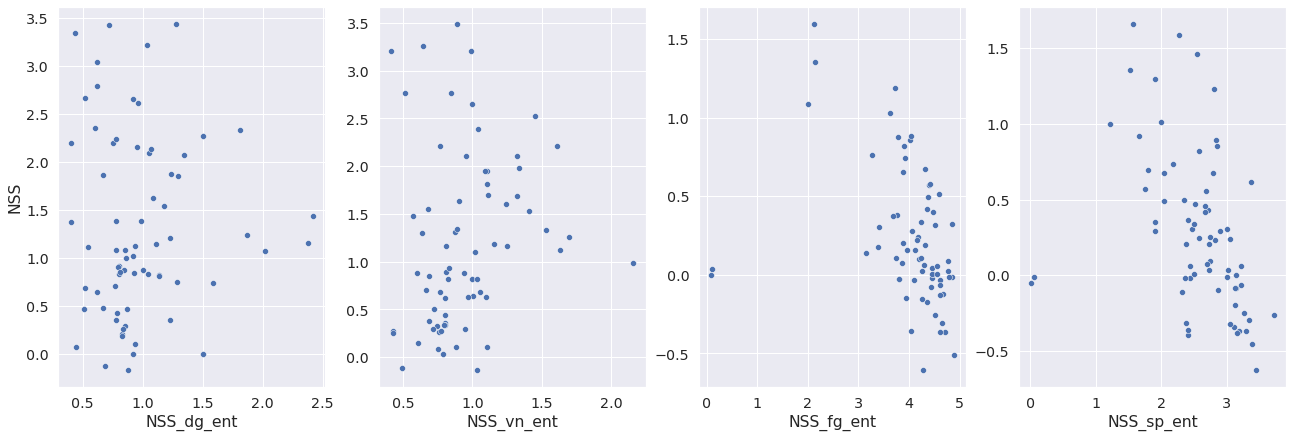

In [154]:
calculate_scenes_corrs_entropy(df_wk, ent['Diary'], wk_data, saliency_models_nss)

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,0.005364,0.230598,-0.180816,-0.208860,-0.029632
NSS_vn,-0.056649,0.191723,-0.175426,-0.187725,-0.136670
NSS_fg,-0.221534,0.107834,-0.361006,-0.428996,0.018756
NSS_sp,-0.295332,-0.109343,-0.319916,-0.407864,-0.027766


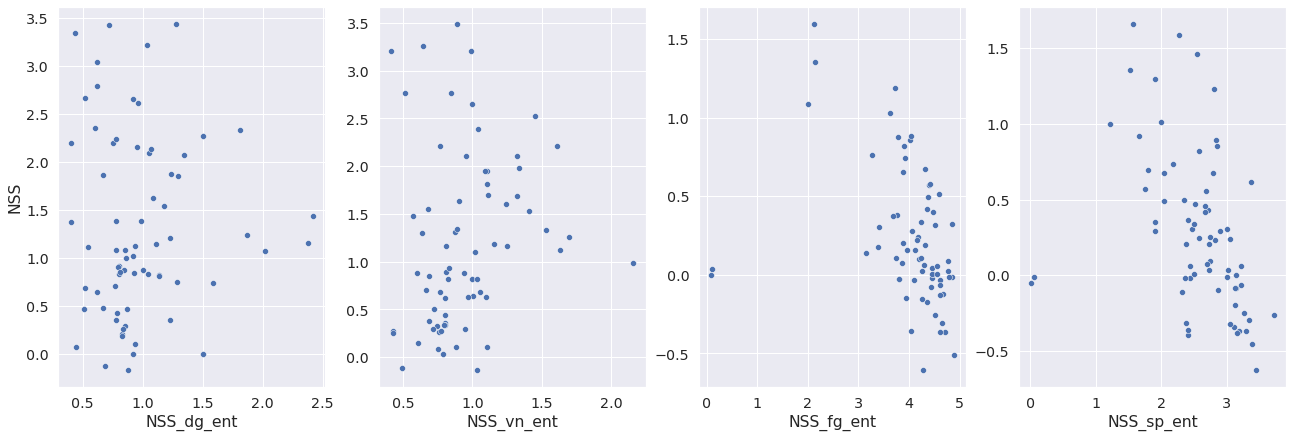

In [155]:
calculate_scenes_corrs_entropy(df_wk, ent['Diary'], wk_data, saliency_models_nss)

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,-0.314803,-0.140379,-0.257928,-0.247575,0.142744
NSS_vn,-0.247675,0.115748,-0.151552,-0.053558,0.251206
NSS_fg,-0.108825,0.022230,-0.307651,-0.165493,-0.210075
NSS_sp,-0.318599,-0.071841,-0.119182,-0.086229,0.010192


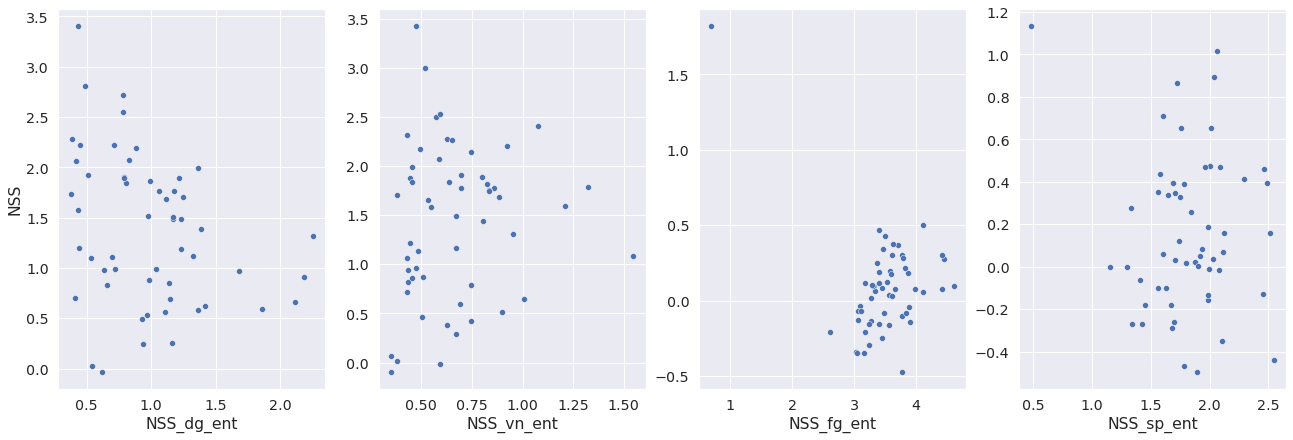

In [156]:
calculate_scenes_corrs_entropy(df_tp, ent['Present'], tp_data, saliency_models_nss)

### Correlation NSS dispersion with entropy per scene

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,-0.175919,0.105112,-0.158924,-0.192304,-0.058327
NSS_vn,-0.047614,0.027440,-0.132010,-0.138007,-0.223275
NSS_fg,-0.280669,-0.227884,0.233742,0.160875,-0.110460
NSS_sp,-0.258064,-0.259681,-0.008341,-0.075978,-0.200690


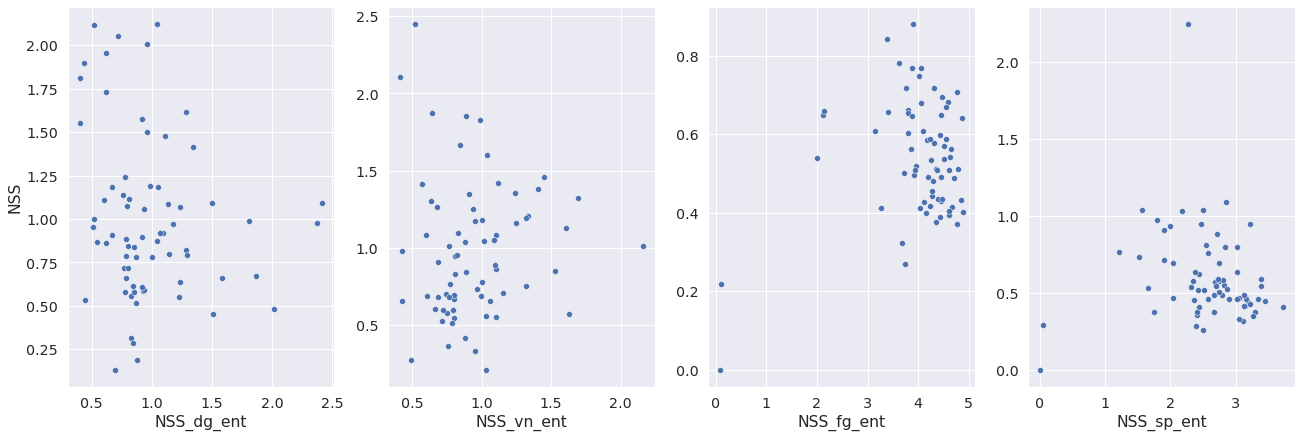

In [157]:
calculate_scenes_corrs_entropy(df_wk, ent['Diary'], wk_data, saliency_models_nss, var='dispersion')

,NSS_dg_ent,NSS_vn_ent,NSS_fg_ent,NSS_sp_ent,FRAME_idx
NSS_dg,-0.558916,-0.293078,-0.217054,-0.316573,0.184599
NSS_vn,-0.415024,-0.200881,-0.074052,-0.093893,0.317635
NSS_fg,-0.092379,0.216733,-0.172284,-0.124721,-0.061794
NSS_sp,-0.277948,0.030544,0.032808,0.027911,0.018542


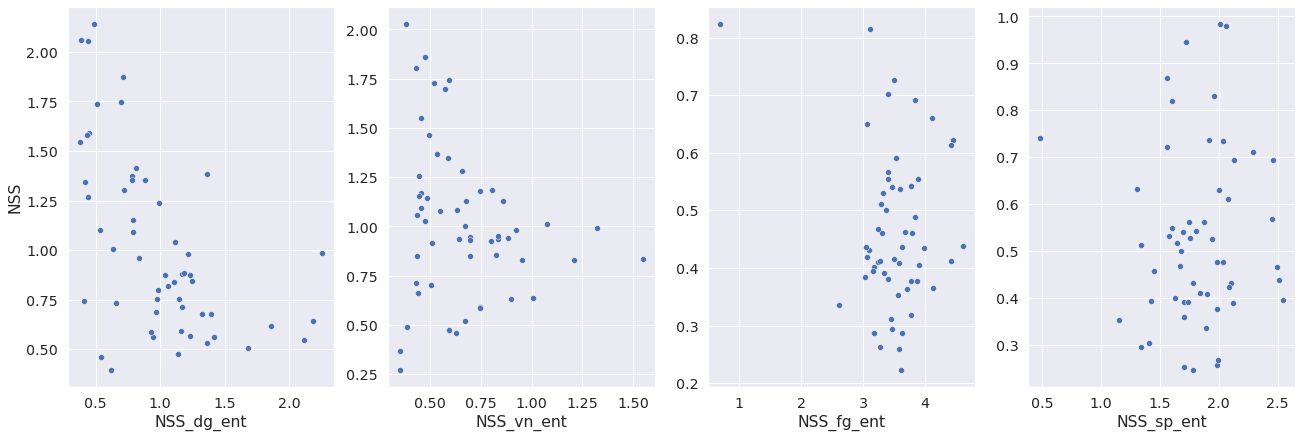

In [120]:
calculate_scenes_corrs_entropy(df_tp, ent['Present'], tp_data, saliency_models_nss, var='dispersion')

## Other features - Faces